Processing Dog images:  53%|█████▎    | 6636/12501 [00:09<00:08, 698.48it/s]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:935: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Processing Dog images: 100%|██████████| 12501/12501 [00:17<00:00, 704.73it/s]


157/157 [==============================] - 544s 3s/step
Test Accuracy: 0.98
Confusion Matrix:
[[2459   56]
 [  52 2433]]


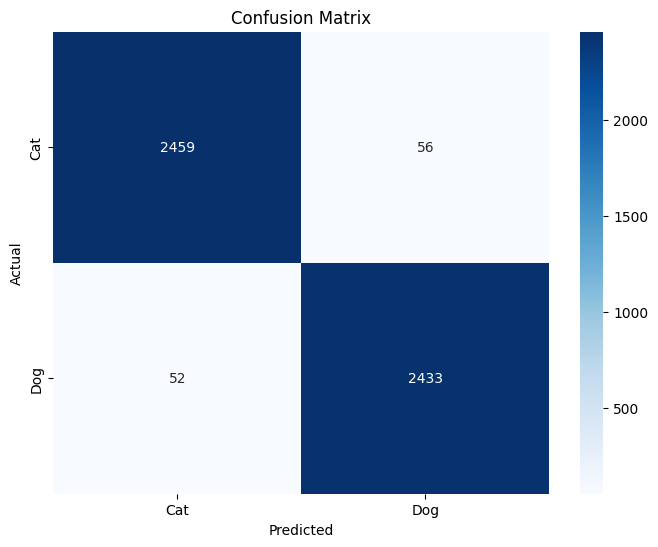

In [ ]:
import os
import zipfile
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model
from tqdm import tqdm

# Step 1: Unzipping the Dataset
zip_file_path = '/content/kagglecatsanddogs_5340.zip'  # Path to uploaded zip file
extract_to_path = '/content/dataset'  # Destination folder

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to_path)

data_dir = os.path.join(extract_to_path, 'PetImages')

# Step 2: Load Images and Labels
def load_data(data_dir, target_size=(150, 150)):
    categories = ['Cat', 'Dog']
    images = []
    labels = []

    for label, category in enumerate(categories):
        category_path = os.path.join(data_dir, category)
        for img_file in tqdm(os.listdir(category_path), desc=f"Processing {category} images"):
            img_path = os.path.join(category_path, img_file)
            try:
                # Load image, resize, and preprocess
                img = load_img(img_path, target_size=target_size)
                img_array = img_to_array(img)
                img_array = preprocess_input(img_array)  # For VGG16
                images.append(img_array)
                labels.append(label)
            except Exception as e:
                continue  # Skip corrupted files

    return np.array(images), np.array(labels)

# Load the dataset
images, labels = load_data(data_dir)

# Step 3: Split Data into Train and Test
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Step 4: Extract Features using VGG16
def extract_features(data):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
    model = Model(inputs=base_model.input, outputs=base_model.output)
    features = model.predict(data, batch_size=32, verbose=1)
    return features.reshape(features.shape[0], -1)

train_features = extract_features(X_train)
test_features = extract_features(X_test)

# Step 5: Train an SVM Classifier
svm_model = SVC(kernel='rbf', C=1, gamma='scale')
svm_model.fit(train_features, y_train)

# Step 6: Evaluate the Model
y_pred = svm_model.predict(test_features)
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Test Accuracy: {accuracy:.2f}")
print("Confusion Matrix:")
print(conf_matrix)

# Step 7: Optional - Save Model and Visualize Results
# Save the trained SVM model (optional)
import joblib
joblib.dump(svm_model, '/content/svm_model.pkl')

# Visualize Confusion Matrix
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Cat', 'Dog'], yticklabels=['Cat', 'Dog'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
